## POS Tagging, HMMs, Viterbi

Let's learn how to do POS tagging by Viterbi Heuristic using tagged Treebank corpus. Before going through the code, let's first understand the pseudo-code for the same. 

1. Tagged Treebank corpus is available (Sample data to training and test data set)
   - Basic text and structure exploration
2. Creating HMM model on the tagged data set.
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)
3. Developing algorithm for Viterbi Heuristic
4. Checking accuracy on the test data set


## 1. Exploring Treebank Tagged Corpus

In [3]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [4]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents())

In [ ]:
# first few tagged sentences
print(wsj[:40])

In [5]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

2739
1175
[[('Other', 'JJ'), ('major', 'JJ'), ('Japanese', 'JJ'), ('computer', 'NN'), ('companies', 'NNS'), ('contacted', 'VBN'), ('*', '-NONE-'), ('yesterday', 'NN'), ('said', 'VBD'), ('0', '-NONE-'), ('they', 'PRP'), ('have', 'VBP'), ('never', 'RBR'), ('made', 'VBN'), ('such', 'JJ'), ('bids', 'NNS'), ('.', '.')], [('But', 'CC'), ('this', 'DT'), ('case', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('stark', 'JJ'), ('lesson', 'NN'), ('in', 'IN'), ('how', 'WRB'), ('the', 'DT'), ('failures', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('traditional', 'JJ'), ('policy-making', 'JJ'), ('process', 'NN'), ('have', 'VBP'), ('left', 'VBN'), ('the', 'DT'), ('courts', 'NNS'), ('as', 'IN'), ('the', 'DT'), ('only', 'JJ'), ('forum', 'NN'), ('0', '-NONE-'), ('this', 'DT'), ('country', 'NN'), ('has', 'VBZ'), ('*T*-2', '-NONE-'), ('0', '-NONE-'), ('*', '-NONE-'), ('to', 'TO'), ('debate', 'VB'), ('risk', 'NN'), (',', ','), ('technology', 'NN'), ('and', 'CC'), ('innovation', 'NN'), ('*T*-3', '-NONE-'), ('*T*-1', '-NONE-

In [6]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70374

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Other',
 'major',
 'Japanese',
 'computer',
 'companies',
 'contacted',
 '*',
 'yesterday',
 'said',
 '0']

In [8]:
# vocabulary
V = set(tokens)
print(len(V))

10147


In [9]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

46

In [10]:
print(T)

{'NNP', 'VBZ', '$', 'IN', 'PRP', 'RP', 'UH', 'WDT', ',', 'NNS', 'TO', "''", 'VBP', 'CD', '-RRB-', 'JJR', 'VB', 'RBS', ':', 'FW', 'SYM', 'WP$', 'JJS', 'JJ', 'LS', '#', 'CC', 'VBD', 'RBR', 'EX', 'DT', 'WP', 'VBN', 'WRB', 'POS', '-LRB-', 'PRP$', '.', 'MD', '-NONE-', '``', 'NN', 'NNPS', 'PDT', 'VBG', 'RB'}


## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'JJ'))
print(word_given_tag('large', 'VB'))
print(word_given_tag('large', 'NN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NN'))
print(word_given_tag('will', 'VB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NN'))
print(word_given_tag('book', 'VB'))

print("\n", "Android")
print(word_given_tag('Android','NN'))


 large
(12, 4024)
(0, 1784)
(0, 9081) 


 will
(188, 642)
(0, 9081)
(0, 1784)

 book
(3, 9081)
(1, 1784)

 Android
(0, 9081)


### Transition Probabilities

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN', 'JJ'))
print(t2_given_t1('NN', 'DT'))
print(t2_given_t1('NNP', 'VB'))
print(t2_given_t1(',', 'NNP'))
print(t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))

print("----")
print(t2_given_t1('VB', 'MD'))

(141, 4024)
(1738, 4024)
(2692, 5705)
(60, 1784)
(1003, 6513)
(1, 1180)
(5, 6513)
----
(518, 642)


In [16]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DT', '.'))
print(t2_given_t1('VBG', '.'))
print(t2_given_t1('NN', '.'))
print(t2_given_t1('NNP', '.'))


(588, 2711)
(8, 2711)
(118, 2711)
(511, 2711)


In [17]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
tags_matrix

array([[3.7709197e-01, 3.7156455e-02, 3.0707815e-04, ..., 0.0000000e+00,
        7.6769537e-04, 7.5234147e-03],
       [2.0338982e-02, 6.7796611e-04, 6.1016949e-03, ..., 6.7796611e-04,
        5.0847456e-02, 1.3016950e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.9498525e-02, 9.8328420e-04, 5.8997050e-03, ..., 9.8328420e-04,
        2.9498525e-03, 3.8348082e-02],
       [3.0105368e-03, 3.7129954e-02, 9.0316106e-03, ..., 0.0000000e+00,
        3.4119420e-02, 7.2252885e-02]], dtype=float32)

In [19]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [20]:
tags_df

,NNP,VBZ,$,IN,PRP,RP,UH,WDT,",",NNS,...,PRP$,.,MD,-NONE-,``,NN,NNPS,PDT,VBG,RB
NNP,0.377092,0.037156,0.000307,0.043759,0.000614,0.000154,0.000000,0.000461,0.154000,0.022877,...,0.000000,0.052050,0.010287,0.004760,0.000768,0.056809,0.017964,0.000000,0.000768,0.007523
VBZ,0.020339,0.000678,0.006102,0.090169,0.013559,0.008136,0.000000,0.000000,0.007458,0.012203,...,0.006780,0.002034,0.000000,0.191186,0.010169,0.042712,0.000000,0.000678,0.050847,0.130169
$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IN,0.148196,0.000290,0.028538,0.017673,0.030566,0.000145,0.000000,0.004056,0.002897,0.064610,...,0.033464,0.002028,0.000000,0.034478,0.006084,0.108359,0.001594,0.000869,0.003766,0.011589
PRP,0.001695,0.188983,0.000000,0.033898,0.000847,0.002542,0.000000,0.000000,0.016949,0.000847,...,0.000000,0.029661,0.122881,0.038136,0.005932,0.005085,0.000000,0.000000,0.004237,0.050847
RP,0.025974,0.000000,0.006494,0.253247,0.000000,0.000000,0.000000,0.000000,0.019481,0.051948,...,0.071429,0.038961,0.000000,0.116883,0.006494,0.045455,0.000000,0.000000,0.000000,0.032468
UH,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
WDT,0.012658,0.003165,0.000000,0.003165,0.044304,0.000000,0.000000,0.000000,0.000000,0.022152,...,0.000000,0.000000,0.003165,0.841772,0.003165,0.006329,0.000000,0.000000,0.000000,0.003165
",",0.137799,0.030688,0.012393,0.079079,0.035704,0.000000,0.000000,0.034819,0.000000,0.027442,...,0.002066,0.000000,0.009737,0.033933,0.014459,0.048687,0.000295,0.000000,0.020655,0.059310
NNS,0.001388,0.009713,0.000231,0.240287,0.002313,0.000231,0.000000,0.015264,0.120028,0.011795,...,0.000231,0.123497,0.025902,0.038853,0.001156,0.021508,0.000000,0.000000,0.009944,0.024977


In [21]:
tags_df.loc['.', :]

NNP       0.188491
VBZ       0.001107
$         0.001107
IN        0.116562
PRP       0.058281
RP        0.000000
UH        0.000000
WDT       0.000738
,         0.000000
NNS       0.046477
TO        0.000738
''        0.062707
VBP       0.000000
CD        0.008115
-RRB-     0.004058
JJR       0.002951
VB        0.000369
RBS       0.000000
:         0.002582
FW        0.000000
SYM       0.000000
WP$       0.000000
JJS       0.001844
JJ        0.033567
LS        0.001844
#         0.000000
CC        0.051641
VBD       0.000738
RBR       0.000369
EX        0.004058
DT        0.216894
WP        0.004058
VBN       0.001475
WRB       0.005902
POS       0.000000
-LRB-     0.003320
PRP$      0.007377
.         0.000000
MD        0.000000
-NONE-    0.018443
``        0.066765
NN        0.043526
NNPS      0.002951
PDT       0.000738
VBG       0.002951
RB        0.036887
Name: ., dtype: float32

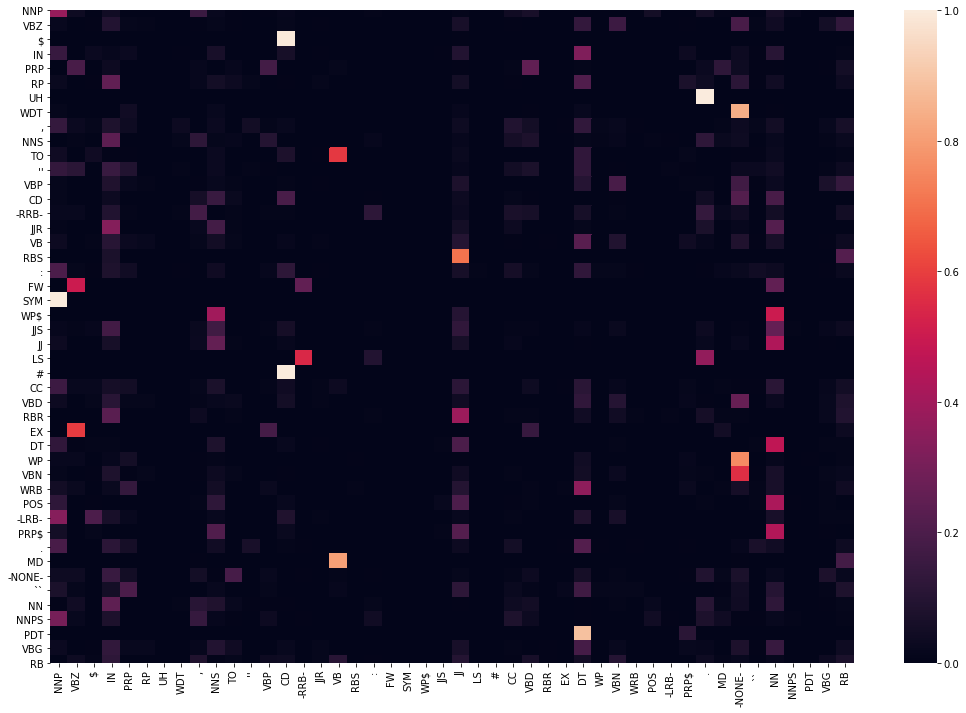

In [22]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


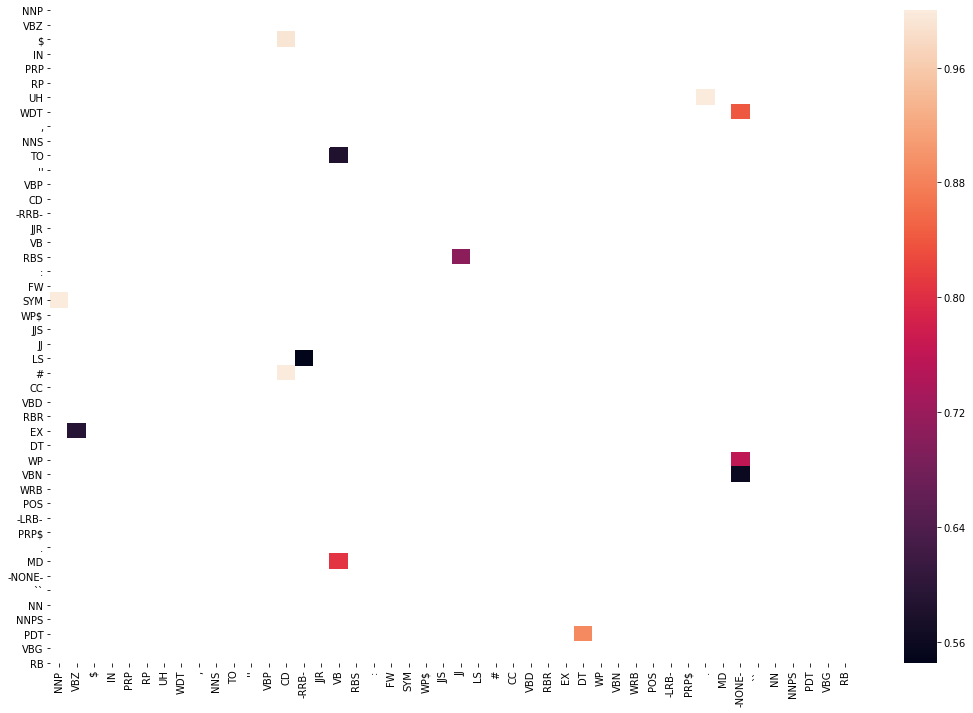

In [23]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [24]:
len(train_tagged_words)

70374

In [25]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

In [26]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Put', 'VB'),
  ('option', 'NN'),
  ('March', 'NNP'),
  ('31', 'CD'),
  (',', ','),
  ('1992', 'CD'),
  (',', ','),
  ('at', 'IN'),
  ('a', 'DT'),
  ('fixed', 'VBN'),
  ('107', 'CD'),
  ('7\\/8', 'CD'),
  ('*', '-NONE-'),
  ('to', 'TO'),
  ('yield', 'VB'),
  ('3.43', 'CD'),
  ('%', 'NN'),
  ('.', '.')],
 [('Vicar', 'NNP'),
  ('Marshall', 'NNP'),
  ('admits', 'VBZ'),
  ('to', 'TO'),
  ('mixed', 'VBN'),
  ('feelings', 'NNS'),
  ('about', 'IN'),
  ('this', 'DT'),
  ('issue', 'NN'),
  (',', ','),
  ('since', 'IN'),
  ('he', 'PRP'),
  ('is', 'VBZ'),
  ('both', 'DT'),
  ('a', 'DT'),
  ('vicar', 'NN'),
  ('and', 'CC'),
  ('an', 'DT'),
  ('active', 'JJ'),
  ('bell-ringer', 'NN'),
  ('himself', 'PRP'),
  ('.', '.')],
 [('Last', 'JJ'),
  ('month', 'NN'),
  (',', ','),
  ('Phoenix', 'NNP'),
  ('voters', 'NNS'),
  ('turned', 'VBD'),
  ('thumbs', 'NNS'),
  ('down', 'RP'),
  ('on', 'IN'),
  ('a', 'DT'),
  ('$', '$'),
  ('100', 'CD'),
  ('million', 'CD'),
  ('*U*', '-NONE-'),
  ('stadium', 'NN'),


In [27]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [28]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  74.47425270080566
[('Put', 'VBN'), ('option', 'NN'), ('March', 'NNP'), ('31', 'CD'), (',', ','), ('1992', 'CD'), (',', ','), ('at', 'IN'), ('a', 'DT'), ('fixed', 'VBN'), ('107', 'NNP'), ('7\\/8', 'CD'), ('*', '-NONE-'), ('to', 'TO'), ('yield', 'VB'), ('3.43', 'NNP'), ('%', 'NN'), ('.', '.'), ('Vicar', 'NNP'), ('Marshall', 'NNP'), ('admits', 'NNP'), ('to', 'TO'), ('mixed', 'VBN'), ('feelings', 'NNP'), ('about', 'IN'), ('this', 'DT'), ('issue', 'NN'), (',', ','), ('since', 'IN'), ('he', 'PRP'), ('is', 'VBZ'), ('both', 'DT'), ('a', 'DT'), ('vicar', 'NN'), ('and', 'CC'), ('an', 'DT'), ('active', 'JJ'), ('bell-ringer', 'NNP'), ('himself', 'PRP'), ('.', '.'), ('Last', 'JJ'), ('month', 'NN'), (',', ','), ('Phoenix', 'NNP'), ('voters', 'NNS'), ('turned', 'VBD'), ('thumbs', 'NNP'), ('down', 'IN'), ('on', 'IN'), ('a', 'DT'), ('$', '$'), ('100', 'CD'), ('million', 'CD'), ('*U*', '-NONE-'), ('stadium', 'NN'), ('bond', 'NN'), ('and', 'CC'), ('tax', 'NN'), ('proposition', 'NN

In [29]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [30]:
accuracy = len(check)/len(tagged_seq)

In [31]:
accuracy

0.8764044943820225

In [32]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [33]:
incorrect_tagged_cases

[[('.', '.'), (('Put', 'VBN'), ('Put', 'VB'))],
 [('fixed', 'VBN'), (('107', 'NNP'), ('107', 'CD'))],
 [('yield', 'VB'), (('3.43', 'NNP'), ('3.43', 'CD'))],
 [('Marshall', 'NNP'), (('admits', 'NNP'), ('admits', 'VBZ'))],
 [('mixed', 'VBN'), (('feelings', 'NNP'), ('feelings', 'NNS'))],
 [('active', 'JJ'), (('bell-ringer', 'NNP'), ('bell-ringer', 'NN'))],
 [('turned', 'VBD'), (('thumbs', 'NNP'), ('thumbs', 'NNS'))],
 [('thumbs', 'NNS'), (('down', 'IN'), ('down', 'RP'))],
 [('.', '.'), (('Everybody', 'NNP'), ('Everybody', 'NN'))],
 [('--', ':'), (('and', 'CC'), ('and', 'IN'))],
 [('auctioned', 'VBN'), (('*-108', 'NNP'), ('*-108', '-NONE-'))]]

In [34]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [35]:
print(tagged_seq)
print(difference)

[('Twitter', 'NNP'), ('is', 'VBZ'), ('the', 'DT'), ('best', 'JJS'), ('networking', 'NN'), ('social', 'JJ'), ('site', 'NNP'), ('.', '.'), ('Man', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('social', 'JJ'), ('animal', 'NNP'), ('.', '.'), ('Data', 'NNP'), ('science', 'NN'), ('is', 'VBZ'), ('an', 'DT'), ('emerging', 'VBG'), ('field', 'NN'), ('.', '.'), ('Data', 'NNP'), ('science', 'NN'), ('jobs', 'NNS'), ('are', 'VBP'), ('high', 'JJ'), ('in', 'IN'), ('demand', 'NN'), ('.', '.')]
23.810627937316895


In [36]:
from nltk import ngrams

sentence = 'this is a foo bar sentences and i want to ngramize it'
sentence = '100% hand-painted canvas oil painting high quality Household adornment art flower pictures DM-15072306'

n = 6
sixgrams = ngrams(sentence.split(), n)

for grams in sixgrams:
    print(grams)

('100%', 'hand-painted', 'canvas', 'oil', 'painting', 'high')
('hand-painted', 'canvas', 'oil', 'painting', 'high', 'quality')
('canvas', 'oil', 'painting', 'high', 'quality', 'Household')
('oil', 'painting', 'high', 'quality', 'Household', 'adornment')
('painting', 'high', 'quality', 'Household', 'adornment', 'art')
('high', 'quality', 'Household', 'adornment', 'art', 'flower')
('quality', 'Household', 'adornment', 'art', 'flower', 'pictures')
('Household', 'adornment', 'art', 'flower', 'pictures', 'DM-15072306')


In [37]:
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence)

start = time.time()
tagged_seq = Viterbi(words)

In [38]:
print(tagged_seq)
print(difference)

[('100', 'CD'), ('%', 'NN'), ('hand-painted', 'NNP'), ('canvas', 'NNP'), ('oil', 'NN'), ('painting', 'NN'), ('high', 'NN'), ('quality', 'NN'), ('Household', 'NNP'), ('adornment', 'NNP'), ('art', 'NN'), ('flower', 'NNP'), ('pictures', 'NNP'), ('DM-15072306', 'NNP')]
23.810627937316895


In [ ]:
100% hand-painted canvas /

oil painting /

high quality Household adornment art /

flower pictures/

(NP 100/CD %/NN hand-painted/JJ canvas/NN)
(NP oil/NN painting/VBG)
(NP high/JJ quality/NN Household/NNP adornment/JJ art/NN)
(NP flower/NN pictures/VBZ)
(NP DM-15072306/NNP)

MORAZORA Big Size 34-46 2019 New Fashion high heels women pumps thin heel classic white red nude beige sexy ladies wedding shoes

Luxury Woman Elegant Flats Solid Vintage Genuine Leather Sexy Pointed Toe Classic Low Heels Casual Office Lady Mules P16

RELKA Classic Men Fashion Casual Shoes Luxury Flying Round Toe Comfortable Heel Shoes Mixed Color Soft Basic Sports Shoes P95

MORAZORA Russia 2019 Genuine leather boots wool fur fashion knee high boots women warm wool boots round toe winter snow boots

Pet Dog Bed Warming Dog House Soft Material Nest Dog Baskets Fall and Winter Warm Kennel For Cat Puppy Plus size Drop shipping

Ceramic little monk Buddha Statues tea pet creative home furnishing articles small adornment home decor ornament landscape

2018 New Motorcycle Pants Men Moto Jeans Protective Gear Riding Touring Motorbike Trousers Motocross Pants Pantalon Moto Pants

Women's Summer Print Jumpsuit Shorts Casual Loose Short Sleeve V-neck Jumpsuit 10 color

New 2019 Women Tshirt Batman Spiderman Iron Man Captain America Winter Soldier Marvel T Shirt Avengers Costume Comics Superhero


In [69]:

# Example of a simple regular expression based NP chunker.
import nltk
sentence = "Luxury Woman Elegant Flats Solid Vintage Genuine Leather Sexy Pointed Toe Classic Low Heels Casual Office Lady Mules P16"

#Define your grammar using regular expressions
#NP: {<DT>?<JJ>*<NN>} # NP
#JJ?NNNNPJJ?NN?*
#NNVBG
grammar = ('''
    NP: {<CD>?<JJ>?<NN>?<NNP>?<JJ>?<NN>?<VBG>?<VBZ>?}
    ''')

chunkParser = nltk.RegexpParser(grammar)
tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
tagged

[('Luxury', 'NNP'),
 ('Woman', 'NNP'),
 ('Elegant', 'NNP'),
 ('Flats', 'NNP'),
 ('Solid', 'NNP'),
 ('Vintage', 'NNP'),
 ('Genuine', 'NNP'),
 ('Leather', 'NNP'),
 ('Sexy', 'NNP'),
 ('Pointed', 'NNP'),
 ('Toe', 'NNP'),
 ('Classic', 'NNP'),
 ('Low', 'NNP'),
 ('Heels', 'NNP'),
 ('Casual', 'NNP'),
 ('Office', 'NNP'),
 ('Lady', 'NNP'),
 ('Mules', 'NNP'),
 ('P16', 'NNP')]

?<CD>?<NN><NNP*>
<NN><NN>
<NN><NN><NNP*>
<NNP><NNP>

In [70]:
tree = chunkParser.parse(tagged)

In [66]:
for subtree in tree.subtrees():
    print(subtree)

(S
  (NP
    2018/CD
    New/NNP
    Motorcycle/NNP
    Pants/NNP
    Men/NNP
    Moto/NNP
    Jeans/NNP
    Protective/NNP
    Gear/NNP
    Riding/NNP
    Touring/NNP
    Motorbike/NNP
    Trousers/NNP
    Motocross/NNP
    Pants/NNP
    Pantalon/NNP
    Moto/NNP)
  Pants/NNS)
(NP
  2018/CD
  New/NNP
  Motorcycle/NNP
  Pants/NNP
  Men/NNP
  Moto/NNP
  Jeans/NNP
  Protective/NNP
  Gear/NNP
  Riding/NNP
  Touring/NNP
  Motorbike/NNP
  Trousers/NNP
  Motocross/NNP
  Pants/NNP
  Pantalon/NNP
  Moto/NNP)


In [67]:
JJ?NNNNPJJ?NN?*
NNVBG

SyntaxError: invalid syntax (<ipython-input-67-d9f46df91e83>, line 1)

In [84]:
sentence = "Pet Dog Bed Warming Dog House Soft Material Nest Dog Baskets Fall and Winter Warm Kennel For Cat Puppy Plus size Drop shipping"

In [85]:
from textblob import TextBlob

In [86]:
wiki = TextBlob(sentence)

In [87]:
wiki.tags

[('Pet', 'NNP'),
 ('Dog', 'NNP'),
 ('Bed', 'NNP'),
 ('Warming', 'NNP'),
 ('Dog', 'NNP'),
 ('House', 'NNP'),
 ('Soft', 'NNP'),
 ('Material', 'NNP'),
 ('Nest', 'NNP'),
 ('Dog', 'NNP'),
 ('Baskets', 'NNP'),
 ('Fall', 'NNP'),
 ('and', 'CC'),
 ('Winter', 'NNP'),
 ('Warm', 'NNP'),
 ('Kennel', 'NNP'),
 ('For', 'IN'),
 ('Cat', 'NNP'),
 ('Puppy', 'NNP'),
 ('Plus', 'NNP'),
 ('size', 'NN'),
 ('Drop', 'NNP'),
 ('shipping', 'NN')]

In [88]:
wiki.noun_phrases

WordList(['pet dog bed warming dog', 'soft material nest dog baskets', 'winter warm kennel', 'cat puppy', 'drop'])